In [151]:
import qiskit
import qiskit_machine_learning as qml
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA, SNOBFIT
from qiskit.circuit import Parameter, ParameterExpression, ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels.parameterized_quantum_kernel import ParamQuantumKernel
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit_machine_learning.algorithms import QSVC


from qiskit import QuantumCircuit, Aer
from qiskit.aqua import QuantumInstance

import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial,reduce
import numpy as np
import copy
from copy import deepcopy as dc

# Generate a trivial dataset

In [152]:
x_vec = [[ 0,  2],
         [.1, .4],
         [.5, .3],
         [.8, .2]]
y = [1, 1, -1, -1]

### Define the objective function used to train the PQK

In [222]:
def std_align(params, PQK=None, x_vec=None, y=None):
    assert PQK is not None
    assert x_vec is not None
    assert y is not None
    
    # check that params are the right dimension
    PQK.bind_free_params(params)
    K = PQK.evaluate(x_vec)
    y = np.array(y)
    
    # The -1 is here because qiskit 
    # optimizers minimize by default
    return -1 * y.T @ K @ y

def weighted_align(params, 
                   PQK=None, 
                   x_vec=None, 
                   y=None):
    assert PQK is not None
    assert x_vec is not None
    assert y is not None
    
    # check that params are the right dimension
    PQK.bind_free_params(params)
    
    qsvc = QSVC(quantum_kernel = PQK)
    qsvc.fit(x_vec, y)
    score = qsvc.score(x_vec, y)

    # The dual coefficients are equal
    # to the Lagrange multipliers, termwise
    # multiplied by the corresponding datapoint's 
    # label. 
    a = qsvc.dual_coef_[0]
    sv = qsvc.support_
    K = PQK.evaluate(x_vec)[sv,:][:,sv]

    # The -1 is here because qiskit 
    # optimizers minimize by default
    return -1 * a.T @ K @ a

### Instantiate and train the PQK

In [148]:
#cb_results_hist = []

In [ ]:

# Define my feature map, partition my parameters
n_qubits = 4
fm = ZZFeatureMap(n_qubits, reps=2)
input_params = fm.parameters[::2]
free_params = fm.parameters[1::2]

# instantiate a simulator backend
qi = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))

# Define my parameterized Kernel
pqk = ParamQuantumKernel(fm, free_params, input_params, quantum_instance=qi)

# Bind neccesary inputs to objective_function, such that it
# has `f(free_param_values) = real-scalar` usage.
#alignment = partial(std_align, PQK=pqk, x_vec=x_vec, y=y)
alignment = partial(weighted_align, PQK=pqk, x_vec=x_vec, y=y)


cb_results = [[],[],[],[],[]]
def callback(x0,x1=None,x2=None,x3=None,x4=None):
    cb_results[0].append(x0)
    cb_results[1].append(x1)
    cb_results[2].append(x2)
    cb_results[3].append(x3)
    cb_results[4].append(x4)
    
# instantiate an optimizer
optimizer = SPSA(maxiter = 2500, callback=callback)
#optimizer = SLSQP(maxiter = 10, callback=callback)
cb_results_hist.append(cb_results)

# do kernel alignment
results = pqk.train_kernel(objective_function=alignment, 
                           optimizer=optimizer)

results.__dict__

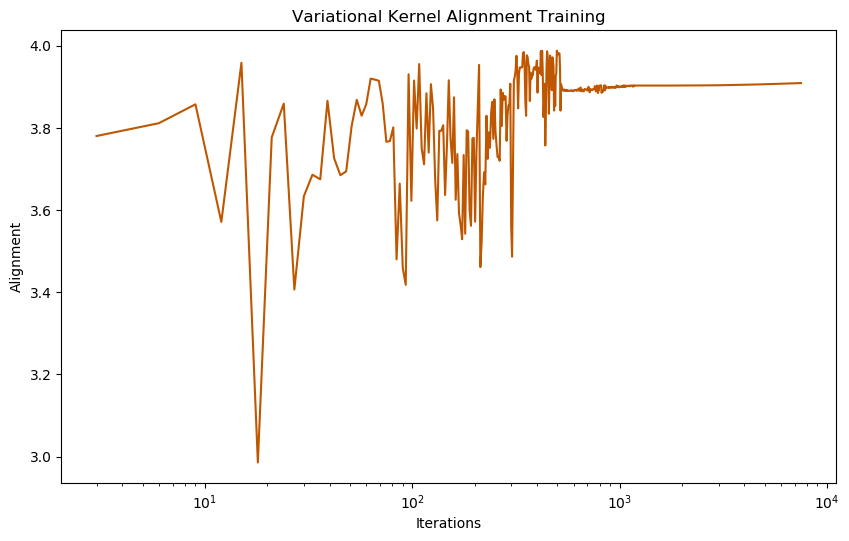

In [191]:
results = cb_results_hist[-1]
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 100
plt.plot(results[0][:2500], -1*np.array(results[2][:2500]), color='#bf5700')
plt.xlabel('Iterations')
plt.ylabel('Alignment')
plt.title("Variational Kernel Alignment Training")
plt.xscale('log')


# Below is the actual kernel matrix we learned
### Note that the data is sorted by class, so theoretically optimal kernel would be block diagonal: 

$K_{ideal}$ = ```[[1, 1, 0, 0]
        [1, 1, 0, 0]
        [0, 0, 1, 1]
        [0, 0, 1, 1]]```

In [218]:
pqk.evaluate(x_vec)

array([[1.        , 0.93915998, 0.92097768, 0.89593465],
       [0.93915998, 1.        , 0.98549691, 0.95676899],
       [0.92097768, 0.98549691, 1.        , 0.99172581],
       [0.89593465, 0.95676899, 0.99172581, 1.        ]])

In [194]:
qsvc.dual_coef_

array([[-0.90661066, -0.92047696,  0.90598988,  0.92109774]])

# After out PQK has been trained, it can immediately be used as a standard kernel.
### This is possible because the optimal free parameters are automatically bound to the feature map. 
If the user desires, they are also free to set the free parameters to whatever values they wish. 

In [195]:
qsvc = QSVC(quantum_kernel = pqk)
qsvc.fit(x_vec, y)
score = qsvc.score(x_vec, y)
print("Training accuracy = ", score)

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


Training accuracy =  1.0


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


# Re-do with a different feature map + dataset

In [208]:
# This dataset was created to be perfectly separable with the parameterized feature map 
# specified below. Perfect separability occurs when free_params = [0.4, 1.9]
X =  np.array([[0.8706654792362811, 0.2369742757376293], 
      [0.5236444947461981, 0.47706078258840867], 
      [0.32718563532890166, 0.5115873322128263], 
      [0.43386908952550884, 0.7268119714452476], 
      [0.5959016911155639, 0.34661481471692046], 
      [0.784072270815886, 0.56597118587358], 
      [0.7064915357994602, 0.04683842708096886], 
      [0.8720288508400597, 0.3391179272755003], 
      [0.5162437571367566, 0.10036739611370471], 
      [0.38034726220142634, 0.977044551667746], 
      [0.20969548243722935, 0.6526412363347083], 
      [0.30453891143802225, 0.6869816088228596], 
      [0.3747999018613254, 0.3651309902912411], 
      [0.06393682681335267, 0.6539151117867389], 
      [0.06572618538859043, 0.9757767726065338], 
      [0.33144917572376775, 0.6628320750526255], 
      [0.377667541739669, 0.7398903275013423], 
      [0.3238996455451548, 0.6980217247056245], 
      [0.21252022637269152, 0.9156762288662499], 
      [0.8176978256864683, 0.8992809375698265]])
y =  np.array([1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 
      1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 
      1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0])

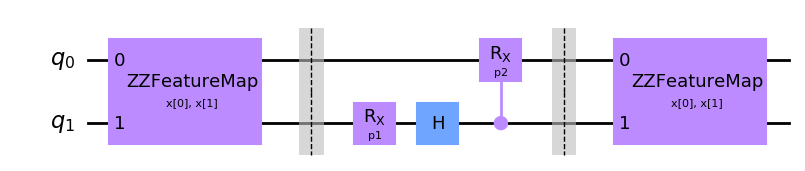

In [201]:
# Define a (non-parameterized) feature map
fm = ZZFeatureMap(2)
input_params = fm.parameters
fm.draw('mpl')
# Define a tunable sub-circuit
W = QuantumCircuit(2)
p1 = Parameter('p1')
p2 = Parameter('p2')
free_params = [p1,p2]
W.barrier()
W.rx(p1, 1)
W.h(1)
W.crx(p2, 1, 0)
W.barrier()
W.draw(output='mpl')
# Compose them to build a parameterized feature map
pfm = fm.compose(W).compose(fm)
pfm.draw(output='mpl')

In [231]:
# instantiate a simulator backend
qi = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))

# Define my parameterized Kernel
pqk = ParamQuantumKernel(pfm, free_params, input_params, quantum_instance=qi)

# Bind neccesary inputs to objective_function, such that it
# has `f(free_param_values) = real-scalar` usage.
#alignment = partial(std_align, PQK=pqk, x_vec=x_vec, y=y)
alignment = partial(weighted_align, PQK=pqk, x_vec=X, y=y)

cb_results = [[],[],[],[],[]]
def callback(x0,x1=None,x2=None,x3=None,x4=None):
    print(x0)
    cb_results[0].append(x0)
    cb_results[1].append(x1)
    cb_results[2].append(x2)
    cb_results[3].append(x3)
    cb_results[4].append(x4)
    
# instantiate an optimizer
optimizer = SPSA(maxiter = 250, callback=callback)
#optimizer = SLSQP(maxiter = 10, callback=callback)
cb_results_hist.append(cb_results)

# do kernel alignment
results = pqk.train_kernel(objective_function=alignment, 
                           optimizer=optimizer,
                           bounds=[[0,2*np.pi],[0,2*np.pi]])

results.__dict__

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


3


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

6


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

9


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

12


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

15


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

18


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

21


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

24


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

27


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

30


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

33


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

36


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

39


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

42


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

45


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

48


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

51


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

54


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

57


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

60


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

63


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

66


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

69


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

72


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

75


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

78


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

81


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

84


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

87


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

90


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

93


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

96


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

99


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

102


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

105


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

108


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

111


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

114


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

117


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

120


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

123


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

126


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

129


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

132


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

135


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

138


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

141


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

144


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

147


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

150


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

153


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

156


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

159


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

162


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

165


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

168


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

171


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

174


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

177


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

180


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

183


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

186


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

189


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

192


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

195


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

198


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

201


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

204


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

207


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

210


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

213


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

216


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

219


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

222


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

225


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

228


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

231


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

234


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

237


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

240


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

243


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

246


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

249


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

252


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

255


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

258


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

261


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

264


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

267


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

270


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

273


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

276


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

279


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

282


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

285


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

288


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

291


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

294


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

297


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

300


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

303


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

306


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

309


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

312


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

315


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

318


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

321


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

324


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

327


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

330


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

333


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

336


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

339


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

342


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

345


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

348


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

351


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

354


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

357


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

360


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

363


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

366


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

369


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

372


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

375


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

378


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

381


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

384


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

387


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

390


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

393


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

396


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

399


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

402


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

405


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

408


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

411


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

414


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

417


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

420


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

423


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

426


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

429


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

432


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

435


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

438


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

441


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

444


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

447


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

450


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

453


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

456


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

459


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

462


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

465


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

468


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

471


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

474


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

477


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

480


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

483


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

486


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

489


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

492


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

495


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

498


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

501


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

504


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

507


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

510


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

513


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

516


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

519


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

522


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

525


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

528


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

531


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

534


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

537


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

540


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

543


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

546


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

549


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

552


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

555


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

558


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

561


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

564


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

567


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

570


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

573


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

576


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

579


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

582


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

585


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

588


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

591


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

594


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

597


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

600


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

603


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

606


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

609


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

612


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

615


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

618


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

621


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

624


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

627


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

630


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

633


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

636


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

639


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

642


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

645


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

648


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

651


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

654


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

657


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

660


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

663


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

666


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

669


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

672


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

675


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

678


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

681


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

684


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

687


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

690


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

693


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

696


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

699


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

702


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

705


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

708


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

711


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

714


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

717


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

720


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

723


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

726


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

729


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

732


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

735


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

738


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

741


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

744


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

747


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future re

750


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


{'_optimizer_evals': 750,
 '_optimizer_time': 1544.538780927658,
 '_optimal_value': -0.018113960317550054,
 '_optimal_point': array([1.77889444, 0.24633028]),
 '_optimal_parameters': {ParameterVectorElement(x[0]): 1.7788944367133044,
  ParameterVectorElement(x[1]): 0.24633028194819204}}

In [ ]:
feature_map = pqk._feature_map

In [226]:
np.array([-40.32301015,  32.4981286 ])% (2*np.pi)

array([3.659287  , 1.08220206])

Text(0.5, 1.0, 'Variational Kernel Alignment Training')

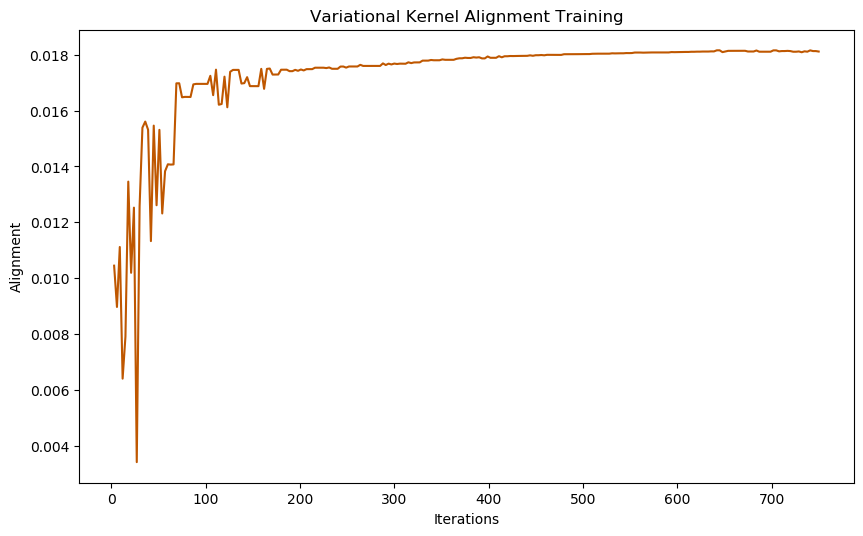

In [233]:
results = cb_results_hist[-1]
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 100
plt.plot(results[0][:2500], -1*np.array(results[2][:2500]), color='#bf5700')
plt.xlabel('Iterations')
plt.ylabel('Alignment')
plt.title("Variational Kernel Alignment Training")


In [230]:
results

[[3, 6, 9, 12, 15, 18, 21, 24, 27, 30],
 [array([1.09386803, 0.20450531]),
  array([ 2.25989772, -0.96152438]),
  array([ 2.06888881, -1.15253329]),
  array([ 2.26201455, -1.34565902]),
  array([ 2.2325688 , -1.31621327]),
  array([ 2.32771371, -1.41135819]),
  array([ 2.23561891, -1.50345299]),
  array([ 1.63504839, -2.1040235 ]),
  array([ 1.78713038, -2.25610548]),
  array([ 2.18515691, -2.65413202])],
 [-0.00614159206670192,
  -0.0018452141838915484,
  -0.0028230889671202724,
  -0.0060636740582615985,
  -0.005102280218279499,
  -0.007053965890885985,
  -0.009758734680874709,
  -0.0042003542485215,
  -0.015458586357211007,
  -0.010290423311618127],
 [0.25281429009318945,
  1.6490150026001098,
  0.2701273870264174,
  0.27312103395117837,
  0.04164257909573595,
  0.13455522633093672,
  0.13024172011344223,
  0.8493349620851169,
  0.21507640104639553,
  0.5628945264403761],
 [True, True, True, True, True, True, True, True, True, True]]

In [232]:
pfm